In [16]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import japanize_matplotlib
from os.path import join
from settings import geodatadir
import itertools
from shapely.geometry import Point, LineString, MultiLineString
# 地図は背景に地理院地図（国土地理院）を使用している場合があります。

In [17]:
mesh_codes = list(itertools.chain.from_iterable(
    [(np.array([5238, 5239, 5240]) + xx) for xx in [0, 100, 200, 300]]))

In [18]:
mesh = gpd.read_file('data/syutoken_mesh.geojson', crs=2451)

In [19]:
kokusei = pd.concat([pd.read_csv(join(geodatadir, f"kokutyou500/tblT000847H{x}.txt"), encoding='sjis', skiprows=[1]) for x in mesh_codes])
kokusei = kokusei[['KEY_CODE', 'T000847001']]
kokusei.columns = ['KEY_CODE', 'people']
kokusei.KEY_CODE = kokusei.KEY_CODE.astype(str)
kokusei = pd.merge(mesh, kokusei, on='KEY_CODE')
kokusei['area_t'] = kokusei.area

In [20]:
keizai = pd.concat([pd.read_csv(join(geodatadir, f"keizai500/tblT000389H{x}.txt"), encoding='sjis', skiprows=1) for x in mesh_codes])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')

In [21]:
stations = gpd.read_file(join(geodatadir, 'stations.geojson'), crs=4612).to_crs(2451)
syochiki = gpd.read_file(join(geodatadir, '../kokusei2020/syochiki/kanto.geojson'), crs=4612).to_crs(2451)

In [47]:
#stations[stations.N02_005 == '東京'].geometry.values[0].centroid.buffer(1000).exterior.coords.xy
tokyoeki = stations[stations.N02_005 == '東京'].geometry.values[0]
x = gpd.overlay(keizai, gpd.GeoDataFrame([None], geometry=[tokyoeki.buffer(10000)], crs=2451))
tokyo_syugyo = x.people.sum()
ans = []
for n in range(10000, 65000, 1000):
    x = gpd.overlay(keizai, gpd.GeoDataFrame([None], geometry=[tokyoeki.buffer(n)], crs=2451))
    x = tokyo_syugyo / x.people.sum()
    ans.append([n, round(x * 100)])
syugyo_buffer = pd.DataFrame(ans)

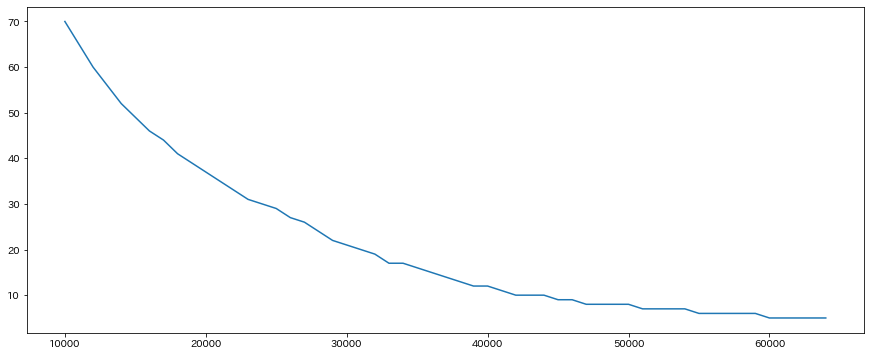

In [50]:
ans.to_csv('output/syugyo-buffer.csv', index=None)
plt.figure(figsize=(15, 6))
plt.plot(ans[0], ans[1] - 30)
plt.show()

In [59]:
syugyo_buffer = pd.concat([
    pd.DataFrame([[x, 100] for x in range(0, 10000, 1000)]),
    syugyo_buffer
])
syugyo_buffer[0] = syugyo_buffer.astype(str)

,0,1
0,0,100
1,1000,100
2,2000,100
3,3000,100
4,4000,100
...,...,...
50,60000,35
51,61000,35
52,62000,35
53,63000,35


In [70]:
syugyo_buffer.columns = ['tokyo2', 'com_p']
syugyo_buffer = syugyo_buffer.drop_duplicates()

In [99]:
csta = gpd.read_file('data/create-line-point.geojson').drop(['index_right'], 1)
csta['tokyo'] = csta.geometry.distance(tokyoeki).astype(int)
csta['tokyo2'] = round(csta.tokyo, -3).astype(str)
csta2 = pd.merge(csta, syugyo_buffer, on='tokyo2')
csta2.com_p = csta2.com_p - 30
csta2['com'] = (csta2.s.fillna(0) * (csta2.com_p / 100) * 0.6 * 0.5).astype(int)
csta2.com = csta2.com.replace(0, np.nan)
csta2[csta2.railno == 73].dropna(subset=['s'])

,railno,idx,ans,s,s2,c,S_NAME,s_name_2,geometry,tokyo,tokyo2,com_p,com
14,73,36500,7521,7521.0,7521.0,NaN,丸の内一丁目,丸の内,POINT (-5918.423 -35374.207),14,0,70,1579.0
73,73,36510,2908,2908.0,NaN,NaN,千代田,千代田,POINT (-6822.412 -34946.652),942,1000,70,610.0
143,73,36520,18852,18852.0,NaN,NaN,北の丸公園,北の丸公園,POINT (-7726.402 -34519.097),1932,2000,70,3958.0
213,73,36530,39026,39026.0,NaN,NaN,九段北四丁目,九段北,POINT (-8630.391 -34091.542),2929,3000,70,8195.0
283,73,36540,60321,60321.0,NaN,NaN,市谷加賀町二丁目,市谷加賀町,POINT (-9534.380 -33663.987),3928,4000,70,12667.0
353,73,36550,67800,67800.0,67800.0,NaN,若松町,若松町,POINT (-10438.370 -33236.432),4927,5000,70,14238.0
423,73,36560,64366,64366.0,NaN,NaN,大久保二丁目,大久保,POINT (-11342.359 -32808.877),5926,6000,70,13516.0
493,73,36570,72945,72945.0,NaN,NaN,百人町四丁目,百人町,POINT (-12246.348 -32381.321),6926,7000,70,15318.0
563,73,36580,74282,74282.0,NaN,NaN,上落合二丁目,上落合,POINT (-13150.337 -31953.766),7925,8000,70,15599.0
633,73,36590,66340,66340.0,NaN,NaN,上高田五丁目,上高田,POINT (-14054.327 -31526.211),8925,9000,70,13931.0


In [119]:
railname1 = pd.DataFrame(dict(
    railno=[42, 52, 73, 79, 86, 97, 112],
    railname='新東海道線、新東横線、新池袋線、新東上線、新高崎線、新日光線、新常磐線'.split('、')
))
csta3 = pd.merge(
    csta2, railname1, on='railno'
)[['railno', 's_name_2', 'com', 'railname', 'tokyo', 'idx', 'geometry']].dropna()
csta3.com.sum() #[csta3.tokyo >= 10000]

1478717.0

In [107]:
gpd.overlay(keizai, gpd.GeoDataFrame([None], geometry=[tokyoeki.buffer(10000)], crs=2451)).people.sum()

5816303

In [112]:
x = pd.merge(
    csta3.groupby('railno').sum().reset_index().drop('tokyo', 1),
    railname1,
    on='railno'
)
x

,railno,com,railname
0,42,231583.0,新東海道線
1,52,204563.0,新東横線
2,73,228202.0,新池袋線
3,79,223518.0,新東上線
4,86,237463.0,新高崎線
5,97,163327.0,新日光線
6,112,190061.0,新常磐線


In [114]:
x.com / 123360 * 100

0    187.729410
1    165.826038
2    184.988651
3    181.191634
4    192.495947
5    132.398671
6    154.070201
Name: com, dtype: float64

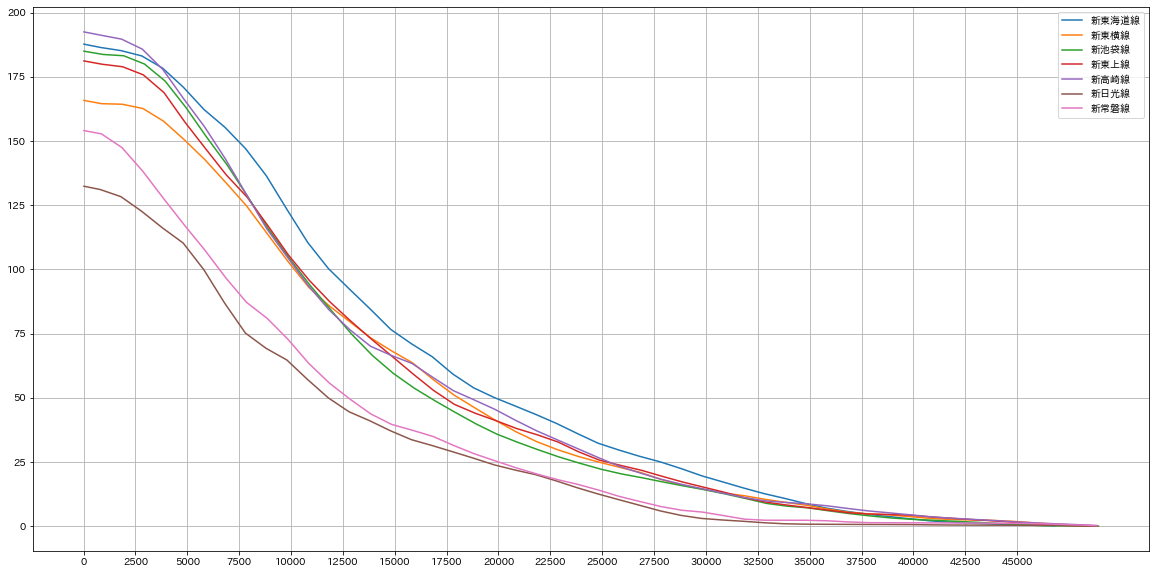

In [147]:
ans = pd.DataFrame()
for n in csta3.railno.unique():
    df = csta3[csta3.railno == n].copy()
    df = df.sort_values('tokyo', ascending=False)
    x = len(df)
    df['jyousya'] = [df.iloc[:xx+1].com.sum() / 123360 * 100 for xx in range(x)]
    ans = pd.concat([ans, df])
ans.to_csv('output/create-railway-1-jyousya.csv', index=None)
plt.figure(figsize=(20, 10))
for n in csta3.railno.unique():
    x = ans[ans.railno == n]
    plt.plot(x.tokyo, x.jyousya, label=x.railname.values[0])
plt.xticks([x for x in range(0, 47500, 2500)])
plt.grid()
plt.legend()
#plt.savefig(x.railname.values[0] + '.png')
#plt.clf()
plt.show()

In [150]:
pd.merge(gpd.read_file('data/create-line-line.geojson'), railname1, on='railno').to_file('data/create-line-line-2.geojson',
    driver='GeoJSON')